Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict, Any, Union
from openpyxl import load_workbook
from tqdm.notebook import tqdm
tqdm.pandas()
# Matplotlib settings all LATEX
import matplotlib
from matplotlib import rc
rc("font", **{"family": "serif", "serif": ["Computer Modern"], "size":18})
rc("text", usetex=True)

In [2]:
sys.path.append("../../nuclearpy_models")
from models.BE import dz_be, semf_be
from models.BE import dz_be, semf_be, sr_be, sr_fast_be
from utils.metrics import RegressionMetrics

In case you want to perform rapid prototyping, you can use the following code to import the version without the uncertainty quantification.

In [3]:
USE_FAST = True
if USE_FAST:
    sr_be = lambda z, n: sr_fast_be(z, n)[0] #! Fast version

In [4]:
PATH_THEORY = "../../Data/Theory/MasterNuclei.xlsx"

## Dataset

In [5]:
exp_df = pd.read_csv('../../Data/Experimental/AME2020.csv', delimiter=',').query("Z>=12").query("Z<=50")

# Binding energy prediction

In [6]:
exp_df["semf_pred"] = exp_df.apply(lambda x: semf_be(x["Z"], x["N"]), axis=1)
exp_df["dz_pred"] = exp_df.apply(lambda x: dz_be(x["Z"], x["N"]), axis=1)
exp_df["sr_pred"] = exp_df.progress_apply(lambda x: sr_be(x["Z"], x["N"]), axis=1)
exp_df["sr_error"] = exp_df["sr_pred"] - exp_df["BE"]
exp_df["dz_error"] = exp_df["dz_pred"] - exp_df["BE"]


  0%|          | 0/1291 [00:00<?, ?it/s]

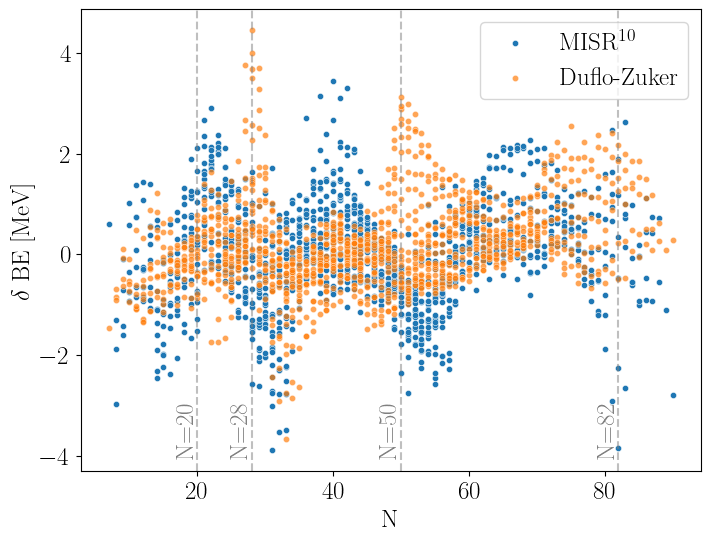

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.scatterplot(data=exp_df, x="N", y="sr_error", label=r"MISR$^{10}$", s=20)
sns.scatterplot(data=exp_df, x="N", y="dz_error", label="Duflo-Zuker", alpha=0.7, s=20)
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.set(xlabel="N", ylabel=r"$\delta$ BE [MeV]")
magic_numbers = [20, 28, 50, 82]
for i in magic_numbers:
    ax.axvline(i, color="grey", linestyle="--", alpha=0.5)
    ax.text(i, -3.5, f"N={i}", rotation=90, verticalalignment="center", horizontalalignment="right", color="grey")
plt.savefig("./plots/sr_dz_error.pdf", bbox_inches="tight")

#### Loading theory model's predictions

In [8]:
PATH_THEORY = "../../Data/Theory/MasterNuclei.xlsx"
def get_sheets_name(filename):
    workbook = load_workbook(filename)
    return workbook.sheetnames
used_dfs = [
    # "DD-ME2",
    # "SKMS",
    "HFB24",
    "NL3S",
    # "UNEDF1",
]
th_datastes = get_sheets_name(PATH_THEORY)
th_datastes = [th_dataste for th_dataste in used_dfs if th_dataste != "AME2020"]

In [9]:
th_datastes

['HFB24', 'NL3S']

In [10]:
thdfs = {th_dataste: pd.read_excel(PATH_THEORY, sheet_name=th_dataste).query("Z >= 12 and N>=12").query("Z<=50") for th_dataste in th_datastes}

In [11]:
def get_th_pred(Z, N, df_th):
    try:
        return df_th[(df_th["Z"] == Z) & (df_th["N"] == N)]["BE"].values[0]
    except:
        return np.nan

def patient_semf(Z, N):
    try:
        return dz_be(Z, N)
    except Exception as e:
        return np.nan

all_th_dfs = {}
all_th_in_exp = {}
for df_name in used_dfs:
    foo = thdfs.get(df_name).copy()
    foo["th_pred"] = foo.apply(lambda x: get_th_pred(x["Z"], x["N"], thdfs[df_name]), axis=1)
    foo["dz_pred"] = foo.apply(lambda x: patient_semf(x["Z"], x["N"]), axis=1)
    foo["dz_diff"] = foo.apply(lambda x: x["dz_pred"] - x["th_pred"], axis=1)
    # foo["sr"] = foo.apply(lambda x: sr_be(x["Z"], x["N"]), axis=1)
    all_th_dfs[df_name] = foo.dropna()
    foo = exp_df.copy()
    foo["th_pred"] = foo.apply(lambda x: get_th_pred(x["Z"], x["N"], thdfs[df_name]), axis=1)
    foo["dz_pred"] = foo.apply(lambda x: patient_semf(x["Z"], x["N"]), axis=1)
    foo["dz_diff"] = foo.apply(lambda x: x["dz_pred"] - x["th_pred"], axis=1)
    # foo["sr"] = foo.apply(lambda x: sr_be(x["Z"], x["N"]), axis=1)
    all_th_in_exp[df_name] = foo.dropna()


# Regression Metrics

In [12]:
semf_metrics = RegressionMetrics(exp_df["BE"], exp_df["semf_pred"], "SEMF")()
dz_metrics = RegressionMetrics(exp_df["BE"], exp_df["dz_pred"], "DZ")()
dz_sr_metrics = RegressionMetrics(exp_df["BE"], exp_df["sr_pred"], "sr")()
results = pd.concat([semf_metrics, dz_metrics, dz_sr_metrics], axis=0)

for df_name in used_dfs:
   res = (RegressionMetrics(all_th_in_exp[df_name]["BE"], all_th_in_exp[df_name]["th_pred"], df_name)())
   results = pd.concat([results, res], axis=0)
all_th_dfs: Dict[str, pd.DataFrame]

results[["RMSE"]].sort_values(by="RMSE", inplace=False).rename(columns={"RMSE": "RMSE [MeV]"})

sr_rmse = results.reset_index().query("index == 'sr'")["RMSE"].values[0]
dz_rmse = results.reset_index().query("index == 'DZ'")["RMSE"].values[0]

In [13]:
results[["MAE", "RMSE"]]

,MAE,RMSE
SEMF,3.630365,5.200893
DZ,0.629198,0.880790
sr,0.806260,1.044236
HFB24,0.549680,0.730337
NL3S,1.992540,2.498961


In [14]:
# 0.769106	0.998873

In [15]:
def plot_isotope_be(
    df: pd.DataFrame,
    models: List[callable] = [dz_be, dz_be],
    model_names: List[str] = ["DZ", "SR"],
    fixed_z: int = 50,
    n_max = 120,
    ):

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    foo_df = df.query(f"Z=={fixed_z}")
    n_min = foo_df["N"].min()
    ns_in = foo_df["N"].values
    ns_out = np.arange(ns_in.max(), n_max)
    all_ns = np.concatenate([ns_in, ns_out])
    y = np.array([dz_be(fixed_z, n) for n in all_ns])
    ax.plot(foo_df["N"], foo_df["BE"]*0, label="Duflo Zuker", color="black", alpha=0.5)
    plt.errorbar(foo_df["N"], foo_df["BE"], yerr=foo_df["uBE"], fmt="o", label="Experiment", color="black")
    ax.hlines(0, n_min, n_max, color="black", linestyle="-")
    SEMF_error = foo_df["dz_pred"] - foo_df["BE"]
    sns.scatterplot(x="N", y=SEMF_error, data=foo_df, ax=ax, label=None, color="black")
    for i, (model, name) in enumerate(zip(models, model_names)):
        preds_in = np.array([model(fixed_z, n) for n in all_ns])
        if isinstance(preds_in[0], (list, np.ndarray)):
            preds_in = [x[0] for x in preds_in]
        print(preds_in)
        errors = y - preds_in
        sns.scatterplot(x=all_ns, y=errors, ax=ax, color=f"C{i}", s=5)
        sns.lineplot(x=all_ns, y=errors, ax=ax, color=f"C{i}", linestyle=":", label=name)
    for j, df_name in enumerate(used_dfs):
        sns.scatterplot(x="N", y="dz_diff", data=all_th_dfs[df_name].query(f"Z=={fixed_z}"), ax=ax, s=10, color=f"C{j+2+i}")
        sns.lineplot(x="N", y="dz_diff", data=all_th_dfs[df_name].query(f"Z=={fixed_z}"), ax=ax, linestyle="--", label=df_name,  color=f"C{j+2+i}")

    ax.set(xlabel="N", ylabel=r"$\delta(BE)$ [MeV]", xlim=(n_min, n_max), ylim=(-10, 10))
    # put the legend in the left down corner
    ax.legend(fontsize=14)
    # Add annotations inside good looking boxes
    ax.annotate(f"Z={fixed_z}", xy=(0.5, 0.9), xycoords="axes fraction", fontsize=22)
    ax.legend(fontsize=14)
    plt.savefig(f"BE_{fixed_z}.pdf", bbox_inches="tight")

# Unseen data

In [16]:
# full_exp_df = pd.read_excel("../../Data/Theory/MasterNuclei.xlsx", sheet_name="AME2020").query("Z>=12").query("Z<=50")
be_test = pd.read_csv("/Users/jose/Documents/Works/MIT/AI/PyMassModels/Data/Experimental/be_test.csv", delimiter=",").query("Z>=12").query("Z<=50")
be_test["is_test"] = [True] * len(be_test)
be_train = pd.read_csv("/Users/jose/Documents/Works/MIT/AI/PyMassModels/Data/Experimental/be_train.csv", delimiter=",").query("Z>=12").query("Z<=50")
be_train["is_test"] = [False] * len(be_train)
full_exp_df = pd.concat([be_test, be_train], axis=0)

In [17]:
%%capture
full_exp_df["sr_cpred"] = full_exp_df.apply(lambda x: sr_be(x["Z"], x["N"]), axis=1)
full_exp_df["sr_pred"] = [x for x in full_exp_df["sr_cpred"]]
full_exp_df["SEMF"] = full_exp_df.apply(lambda x: semf_be(x["Z"], x["N"]), axis=1)
full_exp_df["dz_pred"] = full_exp_df.apply(lambda x: dz_be(x["Z"], x["N"]), axis=1)

In [18]:
full_exp_df = full_exp_df.query("Z > 12 and Z <= 50")

# Smart ensemble of the models

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ARDRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# Create the linear regression model
model_pred_be = make_pipeline(
    PolynomialFeatures(degree=3, include_bias=False, interaction_only=False),
    StandardScaler(),
    ARDRegression(),
)
model_pred_be.fit(full_exp_df.query("is_test == False")[["sr_pred", "dz_pred", "N", "Z"]].values,
          full_exp_df.query("is_test == False")["BE"])

Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('standardscaler', StandardScaler()),
                ('ardregression', ARDRegression())])

In [20]:
def resample_data_from_uncertainties(df: pd.DataFrame) -> pd.DataFrame:
    """
    Resample the data from the uncertainties
    """
    new_target_df = df.copy().sample(frac=0.8, replace=True)
    new_target_df["BE"] = np.random.normal(new_target_df["BE"], new_target_df["uBE"])
    return new_target_df

def train_models_on_resampled_data(df: pd.DataFrame, n_samples: int = 50) -> List[ARDRegression]:
    """
    Train the models on the resampled data
    """
    ndf = df.copy()
    models = []
    for i in tqdm(range(n_samples)):
        sampled_df = resample_data_from_uncertainties(ndf)
        model = make_pipeline(
            PolynomialFeatures(degree=3, include_bias=False, interaction_only=False),
            StandardScaler(),
            ARDRegression(),
        )
        model.fit(sampled_df[["sr_pred", "dz_pred", "N", "Z"]].values, sampled_df["BE"].values)
        models.append(model)
    return models

def get_comitee_predictions(models: List[ARDRegression], X: np.ndarray) -> np.ndarray:
    """
    Get the predictions from the comitee
    """
    preds = np.array([model.predict(X, return_std=True) for model in models])
    m_pred = preds[:, 0, :]
    m_std = preds[:, 1, :]
    all_model_preds = np.mean(m_pred, axis=0)
    all_model_std = np.std(m_pred, axis=0)
    all_model_unce = np.mean(m_std, axis=0)
    return all_model_preds, (all_model_std**2 + all_model_unce**2)**0.5


In [21]:
models = train_models_on_resampled_data(full_exp_df)


  0%|          | 0/50 [00:00<?, ?it/s]

In [22]:
get_comitee_predictions(models, [full_exp_df.query("is_test == True")[["sr_pred", "dz_pred", "N", "Z"]].values[0]])

(array([651.61323636]), array([0.65530109]))

In [23]:
def model_ensemble(Z, N, model=model_pred_be):
    inpupt_sr = sr_be(Z, N)
    inpupt_unc = 0.0
    inpupt_sr = inpupt_sr
    input_dz = dz_be(Z, N)
    # pred, unc = model.predict(np.array([[inpupt_sr, input_dz, N/50, Z/50]]), return_std=True)
    pred, unc = get_comitee_predictions(models, np.array([[inpupt_sr, input_dz, N, Z]]))
    return pred[0], unc


In [24]:
ens =  full_exp_df.progress_apply(lambda x: model_ensemble(x["Z"], x["N"]), axis=1)
ensemble_pred = [x[0] for x in ens]
ensemble_unc = [x[1] for x in ens]
full_exp_df["ensemble_pred"] = ensemble_pred
full_exp_df["ensemble_error"] = full_exp_df["ensemble_pred"] - full_exp_df["BE"]

  0%|          | 0/1266 [00:00<?, ?it/s]

RMSE: 0.578, MAE: 0.424


<Axes: xlabel='N', ylabel='ensemble_error'>

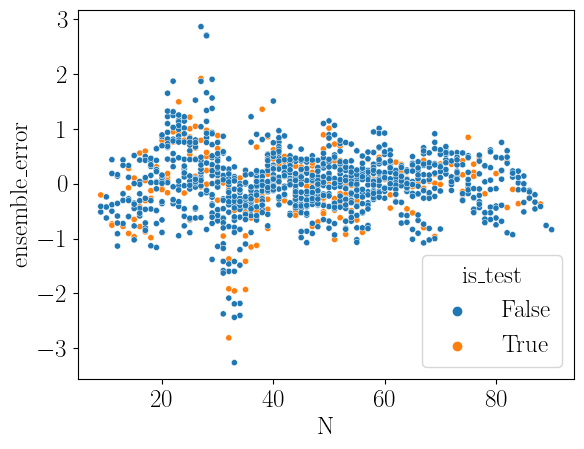

In [25]:
rmse, mae = np.sqrt(np.mean(full_exp_df.query("is_test==1")["ensemble_error"]**2)), np.mean(np.abs(full_exp_df.query("is_test==1")["ensemble_error"]))
print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}")
sns.scatterplot(x="N", y="ensemble_error", data=full_exp_df, s=20, hue="is_test")

<Axes: xlabel='N', ylabel='ensemble_error'>

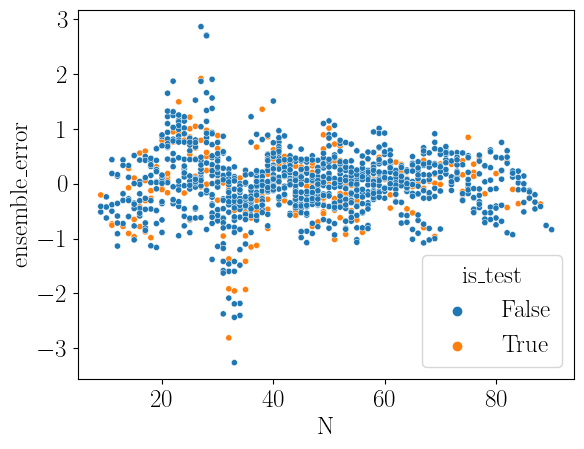

In [26]:
sns.scatterplot(x="N", y="ensemble_error", data=full_exp_df, s=20, hue="is_test")

RMSE: 0.575, MAE: 0.425


In [27]:
trmse, tmae = np.sqrt(np.mean(full_exp_df.query("is_test==0")["ensemble_error"]**2)), np.mean(np.abs(full_exp_df.query("is_test==0")["ensemble_error"]))
print(f"RMSE: {trmse:.3f}, MAE: {tmae:.3f}")

RMSE: 0.570, MAE: 0.412


In [28]:
base_mae = 0.548867
relative_improvement = (base_mae - mae) / base_mae
relative_improvement

0.22754227484710282

# Neutron Separation energies

In [29]:
sep_df = full_exp_df.copy().query("Z>=12")

In [30]:
def predict_sn(Z, N, model):
    model_up = model(Z, N+1)
    model_down = model(Z, N)
    if isinstance(model_up, tuple):
        return model_up[0] - model_down[0], (model_up[1]**2 + model_down[1]**2)**0.5
    else:
        return model_up - model_down

def experimental_sn(df):
    for i, row in df.iterrows():
        try:
            df.at[i, "sn_exp"] = df[(df["Z"] == row["Z"]) & (df["N"] == row["N"]+1)]["BE"].values[0] - row["BE"]
        except:
            df.at[i, "sn_exp"] = np.nan
    return df

def theory_sn(Z, N, th_df):
    try:
        return th_df[(th_df["Z"] == Z) & (th_df["N"] == N+1)]["BE"].values[0] - th_df[(th_df["Z"] == Z) & (th_df["N"] == N)]["BE"].values[0]
    except Exception as e:
        # raise e
        return np.nan


In [31]:
def ensembled_sn(Z, N):
    up_nuclei = model_ensemble(Z, N+1)
    this_nuclei = model_ensemble(Z, N)
    mean_sn = up_nuclei[0] - this_nuclei[0]
    total_unc = (up_nuclei[1]**2 + this_nuclei[1]**2)**0.5
    return mean_sn, total_unc[0]

In [32]:
sep_df["exp_sn"] = experimental_sn(sep_df)["sn_exp"]
sep_df["sr_sn"] = sep_df.apply(lambda x: predict_sn(x["Z"], x["N"], sr_be), axis=1)
sep_df["dz_sn"] = sep_df.apply(lambda x: predict_sn(x["Z"], x["N"], dz_be), axis=1)
ens_sn = sep_df.progress_apply(lambda x: ensembled_sn(x["Z"], x["N"]), axis=1)
sep_df["ensemble_sn"] = [x[0] for x in ens_sn]
sep_df["unc_sn"] = [x[1] for x in ens_sn]

  0%|          | 0/1266 [00:00<?, ?it/s]

In [33]:
for th_name in used_dfs:
    sep_df[f"{th_name}_sn"] = sep_df.apply(lambda x: theory_sn(x["Z"], x["N"], thdfs[th_name]), axis=1)

In [34]:
sep_df

,BE,uBE,N,Z,eBE,x,A,ee,eo,oe,...,ensemble_pred,ensemble_error,sn_exp,exp_sn,sr_sn,dz_sn,ensemble_sn,unc_sn,HFB24_sn,NL3S_sn
2,652.080000,0.400000,39,41,1,4,80,0.0,0.0,0.0,...,651.613236,-0.466764,8.234626,8.234626,16.507529,16.87738,16.757192,0.914762,16.791318,NaN
4,364.994243,0.005311,25,18,0,49,43,0.0,1.0,0.0,...,365.843048,0.848806,11.413220,11.413220,8.332076,8.47238,8.324333,0.904438,9.321318,NaN
6,806.540000,0.294000,49,49,1,0,98,0.0,0.0,0.0,...,806.528597,-0.011403,15.556000,15.556000,15.146975,15.97638,15.971179,1.023504,15.181317,NaN
8,486.964909,0.050002,28,30,0,4,58,1.0,0.0,0.0,...,487.937338,0.972430,12.988123,12.988123,13.060089,12.67238,12.725036,0.935220,13.401317,NaN
9,595.386376,0.000782,38,30,0,64,68,1.0,0.0,0.0,...,595.327564,-0.058812,6.482070,6.482070,6.862171,6.97238,7.027310,0.892635,6.231317,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2740,524.806152,0.000402,33,27,0,36,60,0.0,0.0,0.0,...,524.361899,-0.444253,9.319059,9.319059,9.527051,9.36838,9.367602,0.889448,9.891317,NaN
2744,830.309805,0.035463,52,45,0,49,97,0.0,0.0,1.0,...,830.083565,-0.226240,8.648967,8.648967,8.826922,8.62038,8.579735,0.896625,8.581318,NaN
2745,773.626424,0.370010,47,46,0,1,93,0.0,1.0,0.0,...,773.464518,-0.161906,15.191797,15.191797,14.585533,15.05038,15.005139,0.929348,15.321318,NaN
2746,1103.261000,0.411000,88,49,1,1521,137,0.0,0.0,1.0,...,1102.844904,-0.416096,NaN,NaN,2.423131,1.78738,1.803639,1.030707,1.281318,NaN


In [35]:
def get_experimiental_unc_sn(Z, N, df):
    try:
        return df[(df["Z"] == Z) & (df["N"] == N+1)]["uBE"].values[0] + df[(df["Z"] == Z) & (df["N"] == N)]["uBE"].values[0]
    except:
        return np.nan

In [36]:
dz_rmse = np.sqrt(np.mean((sep_df["exp_sn"] - sep_df["dz_sn"])**2))
sr_rmse = np.sqrt(np.mean((sep_df["exp_sn"] - sep_df["sr_sn"])**2))
ensm_rmse = np.sqrt(np.mean((sep_df["exp_sn"] - sep_df["ensemble_sn"])**2))
print(f"SR RMSE: {sr_rmse}, DZ RMSE: {dz_rmse}, Ensemble RMSE: {ensm_rmse}")

SR RMSE: 1.7753001233052328, DZ RMSE: 1.699810518705291, Ensemble RMSE: 1.6898811000058667


In [92]:
def plot_sn_energy(fixed_z, n_min, n_max, annotation_text="", save_path=None):
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    foo_df = sep_df.query(f"Z=={fixed_z}")# and N>={n_min} and N<={n_max}")
    # predict for models

    pres = [predict_sn(fixed_z, n, model_ensemble) for n in range(n_min, n_max+1)]
    unc_pred = [p[1][0] for p in pres]
    pres = [p[0] for p in pres]

    print(pres, unc_pred)
    predz = [predict_sn(fixed_z, n, dz_be) for n in range(n_min, n_max+1)]
    predsr = [predict_sn(fixed_z, n, sr_be) for n in range(n_min, n_max+1)]
    # experimental
    exp = []
    unc = []
    ns = []
    for n in range(n_min, n_max+1):
        try:
            exp.append(sep_df[(sep_df["Z"] == fixed_z) & (sep_df["N"] == n)]["exp_sn"].values[0])
            unc.append(get_experimiental_unc_sn(fixed_z, n, sep_df))
            ns.append(n)
        except:
            exp.append(np.nan)
            unc.append(np.nan)
    plt.errorbar(range(n_min, n_max+1), exp, yerr=unc, label=None, color="black")
    # scatter as boxes
    sns.scatterplot(x=range(n_min, n_max+1), y=exp, label="Experiment", color="black", marker="s")
    # Color the area between the uncertainty
    ax.fill_between(range(n_min, n_max+1), np.array(exp)-np.array(unc), np.array(exp)+np.array(unc), color="black", alpha=0.1)
    # For uncertainty
    print(len(unc), len(foo_df["exp_sn"]))

    sns.lineplot(x="N", y="exp_sn", data=foo_df, color="black")
    # For sr... put the errorbars in the area wehre there are experimental data
    # no line for the pres
    plt.errorbar(range(n_min, n_max+1), pres, yerr=unc_pred, fmt='.r', label="Ens.", color="blue", capsize=5, alpha=0.5)
    # after the experimental data ends (max(ns)), fill the area with the uncertainty

    # sns.scatterplot(x=range(n_min, n_max+1), y=pres, label="Ensemble", color="red", s=200, marker="_")
    # For dz
    sns.scatterplot(x=range(n_min, n_max+1), y=predz, label="Duflo Zucker", color="red", marker="*", s=200)
    # For sr
    sns.scatterplot(x=range(n_min, n_max+1), y=predsr, label="MISR", color="orange", marker="_", s=200)

    sns.scatterplot(x="N", y="HFB24_sn", data=foo_df, label="HFB24", color="green", marker="x", s=80)
    # Plot an horizontal line at 0
    ax.hlines(0, n_min, n_max, color="black", linestyle="--", alpha=0.5)
    # sns.scatterplot(x="N", y="ensemble_sn", data=foo_df, label="Ensemble", color="orange")
    ax.set(xlabel="N", ylabel=r"$S_n$ [MeV]")
    ax.set_xlim(n_min, n_max+1)
    ax.set_ylim(-5, 8)
    ax.legend(fontsize=22, loc="lower left")
    # Add an annotation for the $Z$ value and text
    if annotation_text:
        ax.annotate(annotation_text, xy=(0.5, 0.9), xycoords="axes fraction", fontsize=22)
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")


[4.196000878630059, 5.430484932670652, 3.1378584435469747, 4.403090483164021, 2.342874287901111, 3.4833517185888923, 1.6697982807250469, 2.706019963918095, 1.106708310387262, 2.051556624732825, 0.6358726622089534, 1.6521588668623508, 0.20647109625963367, 0.9865130446293051, -0.11900831333900896, 0.7282239666309351] [0.9163651345786163, 0.9143696053132451, 0.9213439621535586, 0.9236780034164414, 0.9276348885470548, 0.9326780209892268, 0.9405742023476277, 0.9496346613864386, 0.9617859762147024, 0.9760867575657275, 0.9941193378456935, 1.0172301002787314, 1.053378575948758, 1.150268000605372, 1.280491858265192, 1.4796569551419774]
16 29


/var/folders/zg/s97g7gnj27z83xl9nrhntgxm0000gn/T/ipykernel_62252/566962299.py:36: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".r" (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(range(n_min, n_max+1), pres, yerr=unc_pred, fmt='.r', label="Ens.", color="blue", capsize=5, alpha=0.5)


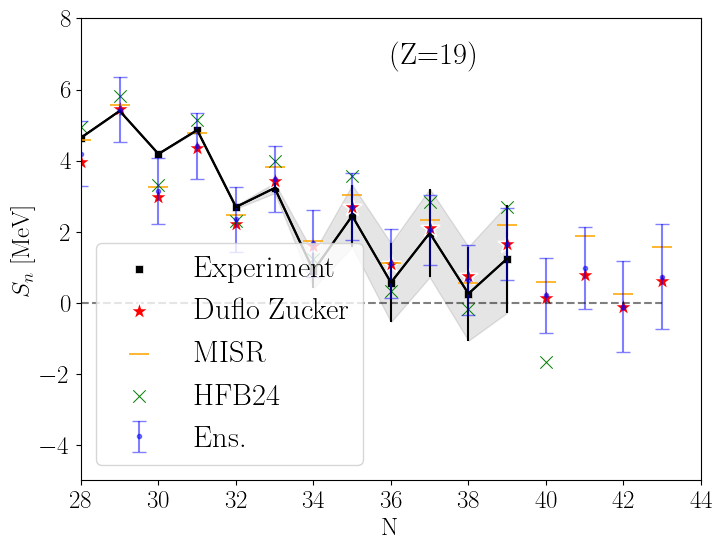

In [96]:
plot_sn_energy(19, 28, 43, "(Z=19)", "sn_19.pdf")

[3.9704750611601867, 1.4342155159772574, 3.3479684880234117, 0.9264640984135326, 2.816919444825942, 0.27149010311569555, 2.0517728589692297, -0.1573620011457706, 1.7132124849212005, -0.42542776229618084, 1.4215410749687862, -0.6596227359311229, 1.1650521867966859, -0.8689718824549573, 0.9342879030211293, -2.3428793766977947, -0.710827662737131, -2.806955376623648, -1.1644020810998086, -3.198691955883305, -1.5466400944266638] [0.9282299648992922, 0.9451345370097392, 0.971589802718651, 0.9987524217868113, 1.0370266077365125, 1.087043806691041, 1.174265547953846, 1.2691752712635889, 1.3855849189110079, 1.4988323066660347, 1.6366578956115503, 1.7782287485885686, 1.9647887317316421, 2.1863781417088264, 2.4959722125085326, 2.8662966817697373, 3.3253069156149997, 3.847854297475602, 4.485614461316252, 5.209500073134781, 6.068731484243282]
21 29


/var/folders/zg/s97g7gnj27z83xl9nrhntgxm0000gn/T/ipykernel_62252/557180713.py:36: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".r" (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(range(n_min, n_max+1), pres, yerr=unc_pred, fmt='.r', label="f(MISR)", color="blue", capsize=5, alpha=0.5)


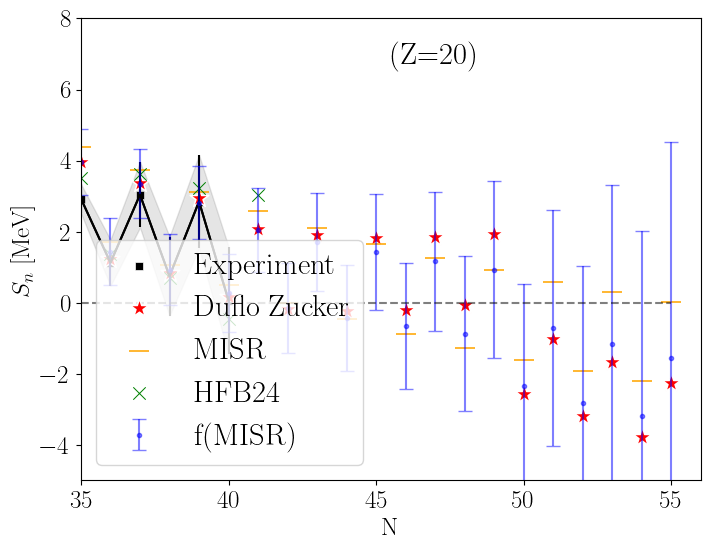

In [91]:
plot_sn_energy(20, 35, 55, "(Z=20)")

# Proton Separation energies
Now we will repeat the same process for the proton separation energies.

In [40]:
# do the same we had for the neutron separation energy but now for protons
def predict_sp(Z, N, model):
    model_up = model(Z+1, N)
    model_down = model(Z, N)
    if isinstance(model_up, tuple):
        return model_up[0] - model_down[0], (model_up[1]**2 + model_down[1]**2)**0.5
    else:
        return model_up - model_down

def experimental_sp(df):
    for i, row in df.iterrows():
        try:
            df.at[i, "sp_exp"] = df[(df["Z"] == row["Z"]+1) & (df["N"] == row["N"])]["BE"].values[0] - row["BE"]
        except:
            df.at[i, "sp_exp"] = np.nan
    return df

def theory_sp(Z, N, th_df):
    try:
        return th_df[(th_df["Z"] == Z+1) & (th_df["N"] == N)]["BE"].values[0] - th_df[(th_df["Z"] == Z) & (th_df["N"] == N)]["BE"].values[0]
    except Exception as e:
        # raise e
        return np.nan


In [41]:
def get_experimiental_unc_sp(Z, N, df):
    try:
        return df[(df["Z"] == Z+1) & (df["N"] == N)]["uBE"].values[0] + df[(df["Z"] == Z) & (df["N"] == N)]["uBE"].values[0]
    except:
        return np.nan

In [42]:
for th_name in used_dfs:
    sep_df[f"{th_name}_sp"] = sep_df.apply(lambda x: theory_sp(x["Z"], x["N"], thdfs[th_name]), axis=1)

In [43]:
sep_df

,BE,uBE,N,Z,eBE,x,A,ee,eo,oe,...,sn_exp,exp_sn,sr_sn,dz_sn,ensemble_sn,unc_sn,HFB24_sn,NL3S_sn,HFB24_sp,NL3S_sp
2,652.080000,0.400000,39,41,1,4,80,0.0,0.0,0.0,...,8.234626,8.234626,16.507529,16.87738,16.757192,0.914762,16.791318,NaN,1.218985,NaN
4,364.994243,0.005311,25,18,0,49,43,0.0,1.0,0.0,...,11.413220,11.413220,8.332076,8.47238,8.324333,0.904438,9.321318,NaN,11.558985,NaN
6,806.540000,0.294000,49,49,1,0,98,0.0,0.0,0.0,...,15.556000,15.556000,15.146975,15.97638,15.971179,1.023504,15.181317,NaN,1.128984,NaN
8,486.964909,0.050002,28,30,0,4,58,1.0,0.0,0.0,...,12.988123,12.988123,13.060089,12.67238,12.725036,0.935220,13.401317,NaN,-1.261016,NaN
9,595.386376,0.000782,38,30,0,64,68,1.0,0.0,0.0,...,6.482070,6.482070,6.862171,6.97238,7.027310,0.892635,6.231317,NaN,6.158984,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2740,524.806152,0.000402,33,27,0,36,60,0.0,0.0,0.0,...,9.319059,9.319059,9.527051,9.36838,9.367602,0.889448,9.891317,NaN,10.068984,NaN
2744,830.309805,0.035463,52,45,0,49,97,0.0,0.0,1.0,...,8.648967,8.648967,8.826922,8.62038,8.579735,0.896625,8.581318,NaN,6.438985,NaN
2745,773.626424,0.370010,47,46,0,1,93,0.0,1.0,0.0,...,15.191797,15.191797,14.585533,15.05038,15.005139,0.929348,15.321318,NaN,-0.001015,NaN
2746,1103.261000,0.411000,88,49,1,1521,137,0.0,0.0,1.0,...,NaN,NaN,2.423131,1.78738,1.803639,1.030707,1.281318,NaN,16.278985,NaN


In [44]:
def ensemble_sp(Z, N, models=models):
    # take two models of models and compute the sn
    up_nuclei = model_ensemble(Z+1, N)
    this_nuclei = model_ensemble(Z, N)
    mean_sn = up_nuclei[0] - this_nuclei[0]
    total_unc = (up_nuclei[1]**2 + this_nuclei[1]**2)**0.5
    return mean_sn, total_unc[0]


In [45]:
sep_df["exp_sp"] = experimental_sp(sep_df)["sp_exp"]
sep_df["sr_sp"] = sep_df.apply(lambda x: predict_sp(x["Z"], x["N"], sr_be), axis=1)
sep_df["dz_sp"] = sep_df.apply(lambda x: predict_sp(x["Z"], x["N"], dz_be), axis=1)
ens_sp = sep_df.progress_apply(lambda x: ensemble_sp(x["Z"], x["N"]), axis=1)
sep_df["ensemble_sp"] = [x[0] for x in ens_sp]
sep_df["unc_sp"] = [x[1] for x in ens_sp]


  0%|          | 0/1266 [00:00<?, ?it/s]

In [83]:
def plot_sp_energy(fixed_z, n_min, n_max, annotation_text="", save_path=None):
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    foo_df = sep_df.query(f"Z=={fixed_z}")# and N>={n_min} and N<={n_max}")
    # predict for models
    pres = [predict_sp(fixed_z, n, model_ensemble) for n in range(n_min, n_max+1)]
    unc_pred = [p[1][0] for p in pres]
    pres = [p[0] for p in pres]
    predz = [predict_sp(fixed_z, n, dz_be) for n in range(n_min, n_max+1)]
    predsr = [predict_sp(fixed_z, n, sr_be) for n in range(n_min, n_max+1)]
    # experimental
    exp = []
    unc = []
    ns = []
    for n in range(n_min, n_max+1):
        try:
            exp.append(sep_df[(sep_df["Z"] == fixed_z) & (sep_df["N"] == n)]["exp_sp"].values[0])
            unc.append(get_experimiental_unc_sn(fixed_z, n, sep_df))
            ns.append(n)
        except:
            exp.append(np.nan)
            unc.append(np.nan)
    plt.errorbar(range(n_min, n_max+1), exp, yerr=unc, label=None, color="black")
    # scatter as boxes
    sns.scatterplot(x=range(n_min, n_max+1), y=exp, label="Experiment", color="black", marker="s")
    # Color the area between the uncertainty
    ax.fill_between(range(n_min, n_max+1), np.array(exp)-np.array(unc), np.array(exp)+np.array(unc), color="black", alpha=0.1)
    # For uncertainty
    print(len(unc), len(foo_df["exp_sp"]))

    sns.lineplot(x="N", y="exp_sp", data=foo_df, color="black")
    # For sr... put the errorbars in the area wehre there are experimental data
    # no line for the pres
    plt.errorbar(range(n_min, n_max+1), pres, yerr=unc_pred, fmt='.r', label="Ens.", color="blue", capsize=5, alpha=0.5)
    # after the experimental data ends (max(ns)), fill the area with the uncertainty

    # sns.scatterplot(x=range(n_min, n_max+1), y=pres, label="Ensemble", color="red", s=200, marker="_")
    # For dz
    sns.scatterplot(x=range(n_min, n_max+1), y=predz, label="Duflo Zucker", color="red", marker="*", s=200)
    # For sr
    sns.scatterplot(x=range(n_min, n_max+1), y=predsr, label="MISR", color="orange", marker="_", s=200)
    # sns.scatterplot(x="N", y="dz_sp", data=foo_df, label="DZ", color="blue")
    sns.scatterplot(x="N", y="HFB24_sp", data=foo_df, label="HFB24", color="green", marker="x", s=80)
    # Plot an horizontal line at 0
    ax.hlines(0, n_min, n_max, color="black", linestyle="--", alpha=0.5)
    # sns.scatterplot(x="N", y="ensemble_sp", data=foo_df, label="Ensemble", color="orange")
    ax.set(xlabel="N", ylabel=r"$S_p$ [MeV]")
    ax.set_xlim(n_min, n_max+1)
    ax.set_ylim(-5, 8)
    ax.legend(fontsize=22, loc="upper left")
    # Add an annotation for the $Z$ value and text
    if annotation_text:
        ax.annotate(annotation_text, xy=(0.5, 0.9), xycoords="axes fraction", fontsize=22)
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")


9 35


/var/folders/zg/s97g7gnj27z83xl9nrhntgxm0000gn/T/ipykernel_62252/415314969.py:33: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".r" (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(range(n_min, n_max+1), pres, yerr=unc_pred, fmt='.r', label="f(MISR)", color="blue", capsize=5, alpha=0.5)


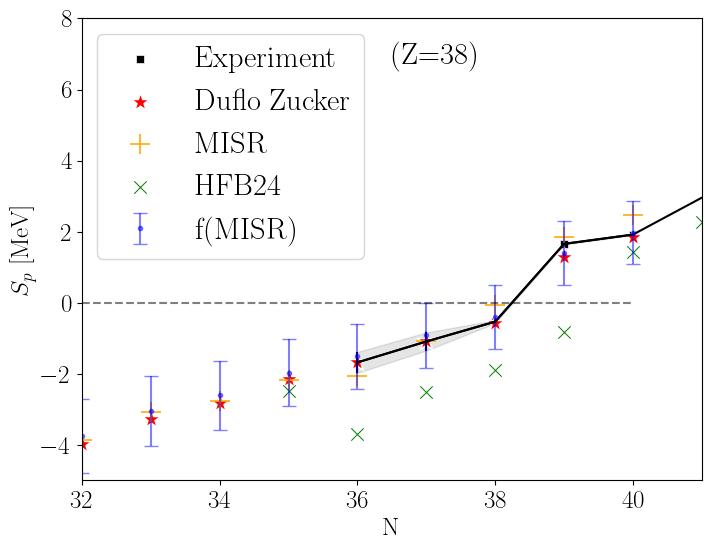

In [84]:
plot_sp_energy(38, 32, 40, "(Z=38)")

# Two neutron separation energies

In [48]:
def predict_s2n(Z, N, model):
    model_up = model(Z, N+2)
    model_down = model(Z, N)
    if isinstance(model_up, tuple):
        return model_up[0] - model_down[0], (model_up[1]**2 + model_down[1]**2)**0.5
    else:
        return model_up - model_down

def experimental_s2n(df):
    for i, row in df.iterrows():
        try:
            df.at[i, "s2n_exp"] = df[(df["Z"] == row["Z"]) & (df["N"] == row["N"]+2)]["BE"].values[0] - row["BE"]
        except:
            df.at[i, "s2n_exp"] = np.nan
    return df

def theory_s2n(Z, N, th_df):
    try:
        return th_df[(th_df["Z"] == Z) & (th_df["N"] == N+2)]["BE"].values[0] - th_df[(th_df["Z"] == Z) & (th_df["N"] == N)]["BE"].values[0]
    except Exception as e:
        # raise e
        return np.nan

def get_experimiental_unc_s2n(Z, N, df):
    try:
        return df[(df["Z"] == Z) & (df["N"] == N+2)]["uBE"].values[0] + df[(df["Z"] == Z) & (df["N"] == N)]["uBE"].values[0]
    except:
        return np.nan

sep_df["exp_s2n"] = experimental_s2n(sep_df)["s2n_exp"]
sep_df["sr_s2n"] = sep_df.apply(lambda x: predict_s2n(x["Z"], x["N"], sr_be), axis=1)
sep_df["dz_s2n"] = sep_df.apply(lambda x: predict_s2n(x["Z"], x["N"], dz_be), axis=1)
ens_s2n = sep_df.progress_apply(lambda x: ensemble_sp(x["Z"], x["N"]), axis=1)
sep_df["ensemble_s2n"] = [x[0] for x in ens_s2n]
sep_df["unc_s2n"] = [x[1] for x in ens_s2n]

  0%|          | 0/1266 [00:00<?, ?it/s]

# Two proton separation energies

In [49]:
def predict_s2p(Z, N, model):
    model_up = model(Z+2, N)
    model_down = model(Z, N)
    if isinstance(model_up, tuple):
        return model_up[0] - model_down[0], (model_up[1]**2 + model_down[1]**2)**0.5
    else:
        return model_up - model_down

def experimental_s2p(df):
    for i, row in df.iterrows():
        try:
            df.at[i, "s2p_exp"] = df[(df["Z"] == row["Z"]+2) & (df["N"] == row["N"])]["BE"].values[0] - row["BE"]
        except:
            df.at[i, "s2p_exp"] = np.nan
    return df

def theory_s2p(Z, N, th_df):
    try:
        return th_df[(th_df["Z"] == Z+2) & (th_df["N"] == N)]["BE"].values[0] - th_df[(th_df["Z"] == Z) & (th_df["N"] == N)]["BE"].values[0]
    except Exception as e:
        # raise e
        return np.nan

def get_experimiental_unc_s2p(Z, N, df):
    try:
        return df[(df["Z"] == Z+2) & (df["N"] == N)]["uBE"].values[0] + df[(df["Z"] == Z) & (df["N"] == N)]["uBE"].values[0]
    except:
        return np.nan

sep_df["exp_s2p"] = experimental_s2p(sep_df)["s2p_exp"]
sep_df["sr_s2p"] = sep_df.apply(lambda x: predict_s2p(x["Z"], x["N"], sr_be), axis=1)
sep_df["dz_s2p"] = sep_df.apply(lambda x: predict_s2p(x["Z"], x["N"], dz_be), axis=1)
ens_s2p = sep_df.progress_apply(lambda x: ensemble_sp(x["Z"], x["N"]), axis=1)
sep_df["ensemble_s2p"] = [x[0] for x in ens_s2p]
sep_df["unc_s2p"] = [x[1] for x in ens_s2p]


  0%|          | 0/1266 [00:00<?, ?it/s]

# Estimation of the probability of the separation energy being positive

In [50]:
import scipy.stats as stats
def probability_less_than_zero(mean, std_dev):
    # Use the CDF to find the probability that a value is less than 0
    probability = stats.norm.cdf(0, mean, std_dev)
    return probability


In [51]:
def estimate_proba_negative_sn(Z, N):
    # Get the mean and standard deviation of the ensemble of models
    # first look on sep_df to see if the values are there precomputed
    if Z in sep_df["Z"].values and N in sep_df["N"].values:
        mean = sep_df[(sep_df["Z"] == Z) & (sep_df["N"] == N)]["ensemble_sn"].values[0]
        std_dev = sep_df[(sep_df["Z"] == Z) & (sep_df["N"] == N)]["unc_sn"].values[0]
    else:
        mean, std_dev = ensembled_sn(Z, N)
    return probability_less_than_zero(mean, std_dev)

def estimate_proba_negative_sp(Z, N):
    # Get the mean and standard deviation of the ensemble of models
    mean, std_dev = ensemble_sp(Z, N)
    # first look on sep_df to see if the values are there precomputed
    if Z in sep_df["Z"].values and N in sep_df["N"].values:
        mean = sep_df[(sep_df["Z"] == Z) & (sep_df["N"] == N)]["ensemble_sp"].values[0]
        std_dev = sep_df[(sep_df["Z"] == Z) & (sep_df["N"] == N)]["unc_sp"].values[0]
    else:
        mean, std_dev = ensemble_sp(Z, N)
    return probability_less_than_zero(mean, std_dev)
def estimate_proba_negative_s2n(Z, N):
    # Get the mean and standard deviation of the ensemble of models
    if Z in sep_df["Z"].values and N in sep_df["N"].values:
        mean = sep_df[(sep_df["Z"] == Z) & (sep_df["N"] == N)]["ensemble_s2n"].values[0]
        std_dev = sep_df[(sep_df["Z"] == Z) & (sep_df["N"] == N)]["unc_s2n"].values[0]
    else:
        mean, std_dev = ensembled_sn(Z, N)
    return probability_less_than_zero(mean, std_dev)
def estimate_proba_negative_s2p(Z, N):
    # Get the mean and standard deviation of the ensemble of models
    if Z in sep_df["Z"].values and N in sep_df["N"].values:
        mean = sep_df[(sep_df["Z"] == Z) & (sep_df["N"] == N)]["ensemble_s2p"].values[0]
        std_dev = sep_df[(sep_df["Z"] == Z) & (sep_df["N"] == N)]["unc_s2p"].values[0]
    else:
        mean, std_dev = ensemble_sp(Z, N)
    return probability_less_than_zero(mean, std_dev)

In [52]:
def estimate_proba_bound(Z, N):
    # Estimate the probability of negative separation energies
    proba_negative_sn = estimate_proba_negative_sn(Z, N)
    proba_negative_sp = estimate_proba_negative_sp(Z, N)
    proba_negative_s2n = estimate_proba_negative_s2n(Z, N)
    proba_negative_s2p = estimate_proba_negative_s2p(Z, N)

    # Calculate the probability of positive separation energies
    proba_positive_sn = 1 - proba_negative_sn
    proba_positive_sp = 1 - proba_negative_sp
    proba_positive_s2n = 1 - proba_negative_s2n
    proba_positive_s2p = 1 - proba_negative_s2p

    # Calculate the total probability of the nucleus being bound
    # Assuming the separation energies are independent
    P_bound = proba_positive_sn * proba_positive_sp * proba_positive_s2n * proba_positive_s2p

    return P_bound


In [53]:
def find_experimental_driplines(df=sep_df):
    # Find the experimental dripline
    exp_sn = df["exp_sn"].values
    exp_sp = df["exp_sp"].values
    exp_s2n = df["exp_s2n"].values
    exp_s2p = df["exp_s2p"].values
    # Find the indices of the bound nuclei
    bound_indices = np.where((exp_sn > 0) & (exp_sp > 0) & (exp_s2n > 0) & (exp_s2p > 0))[0]
    # all the non bound nuclei are the dripline
    dripline_indices = np.where((exp_sn < 0) | (exp_sp < 0) | (exp_s2n < 0) | (exp_s2p < 0))[0]
    return bound_indices, dripline_indices

In [54]:
bound_indices, dripline_indices = find_experimental_driplines()

In [55]:
dripline_indices

array([   1,    3,   21,   43,   65,   73,   75,   82,   86,   87,  118,
        142,  152,  154,  161,  186,  205,  210,  215,  231,  251,  256,
        257,  269,  306,  307,  341,  342,  353,  359,  367,  388,  397,
        413,  424,  431,  461,  466,  472,  481,  483,  504,  522,  548,
        549,  551,  553,  557,  560,  602,  622,  634,  649,  654,  671,
        673,  677,  695,  703,  712,  726,  736,  737,  768,  780,  794,
        802,  804,  824,  827,  867,  871,  892,  896,  901,  907,  909,
        920,  940,  948,  963,  964,  977,  986, 1005, 1018, 1021, 1030,
       1045, 1080, 1086, 1100, 1101, 1122, 1125, 1128, 1132, 1167, 1170,
       1209, 1239])

In [56]:
dripline_z_n = [(z, n) for z, n in zip(sep_df.query("Z>=12 and Z<=50")["Z"].values[dripline_indices], sep_df.query("Z>=12 and Z<=50")["N"].values[dripline_indices])]

In [57]:
estimate_proba_bound(17, 13)

0.4554092758886757

In [58]:
predict_sp(17, 13, model_ensemble), predict_sp(17, 12, model_ensemble)

((0.699399692647404, array([0.94928315])),
 (-0.2082859694496051, array([0.93054209])))

In [59]:
estimate_proba_negative_sp(17, 13)

0.23063228614362635

In [60]:
Z_range = np.arange(13, 45)  # Proton number from 12 to 50 inclusive
N_range = np.arange(10, 60)

In [61]:
if True:
    # Define the ranges for Z and N
    Z_range = np.arange(13, 45)  # Proton number from 12 to 50 inclusive
    N_range = np.arange(10, 60)  # Neutron number up to 150 for demonstration

    # Initialize a matrix to hold the probabilities
    all_bound_matrix = np.full((len(Z_range), len(N_range)), np.inf)
    # proba_matrix_sn = np.full((len(Z_range), len(N_range)), np.inf)
    # proba_matrix_sp = np.full((len(Z_range), len(N_range)), np.inf)
    # proba_matrix_s2n = np.full((len(Z_range), len(N_range)), np.inf)
    # proba_matrix_s2p = np.full((len(Z_range), len(N_range)), np.inf)

    # Calculate the probabilities for the grid of (Z,N) values
    for i, Z in enumerate(tqdm(Z_range)):
        for j, N in enumerate(N_range):
            try:
                all_bound_matrix[i, j] = estimate_proba_bound(Z, N)
            except Exception as e:
                all_bound_matrix[i, j] = 0.


  0%|          | 0/32 [00:00<?, ?it/s]

In [62]:
# all_bound_matrix = (1-proba_matrix_sn) * (1-proba_matrix_sp) * (1-proba_matrix_s2n) * (1-proba_matrix_s2p)

In [63]:
len(N_range),len(Z_range), all_bound_matrix.shape

(50, 32, (32, 50))

In [64]:
dripline_indices = np.array(dripline_indices)

In [65]:
import numpy as np
import matplotlib.pyplot as plt

def plot_nuclear_chart(proba_matrix = all_bound_matrix, title='Nuclear Stability Chart', ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(9, 6))
    proba_matrix = np.where(proba_matrix == 0.000, np.nan, proba_matrix)
    ax.set_facecolor('white')
    cmap = plt.cm.get_cmap('RdYlBu_r').reversed()
    x, y = np.meshgrid(N_range, Z_range)
    chart = ax.pcolormesh(x, y, proba_matrix, cmap=cmap, alpha=0.75, linewidth=0.5, edgecolor='white')
    levels = [0.5]
    ct = ax.contour(N_range, Z_range, proba_matrix, levels, colors='k', linewidths=0.5)
    ax.clabel(ct, fmt='%2.1f', colors='black', fontsize=8)
    dripline_z_n = sep_df.iloc[dripline_indices][["Z", "N"]].values
    dripline_z_n = np.array([x for x in dripline_z_n if (estimate_proba_bound(x[0], x[1]) < 0.99 and Z <= 45 and N <= 80)])
    ax.scatter(dripline_z_n[:, 1], dripline_z_n[:, 0], color='black', s=10, label='Confirmed\n Unbound Nuclei')
    ax.legend(fontsize=20)
    cbar = plt.colorbar(chart, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('$P_{bound}$', rotation=270, labelpad=15)
    ax.set_ylim(12, 45)
    ax.set_xlabel('Neutron number N')
    ax.set_ylabel('Proton number Z')
    ax.set_title(title)
    ax.grid(True, color='black', linestyle='--', linewidth=0.5, alpha=0.5, zorder=0)

/var/folders/zg/s97g7gnj27z83xl9nrhntgxm0000gn/T/ipykernel_62252/2697639396.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlBu_r').reversed()


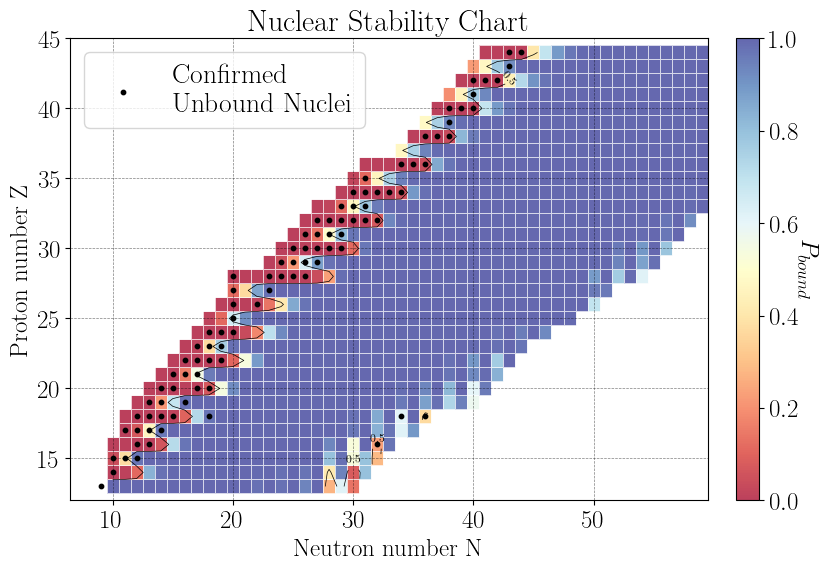

In [66]:

# Plot the probability matrix with the improved styling function
plot_nuclear_chart( all_bound_matrix)

# Error analyisis

In [67]:
probabilities_sp = [estimate_proba_bound(z, n) for z, n in tqdm(dripline_z_n)]


  0%|          | 0/101 [00:00<?, ?it/s]

In [68]:
def predict_bound_single_model(Z, N, model):
    # Get the mean and standard deviation of the ensemble of models
    sp_pred = predict_sp(Z, N, model)
    sn_pred = predict_sn(Z, N, model)
    s2n_pred = predict_s2n(Z, N, model)
    s2p_pred = predict_s2p(Z, N, model)
    # Calculate the probability of the nucleus being bound
    return (sp_pred > 0) and (sn_pred > 0) and (s2n_pred > 0) and (s2p_pred > 0)

In [69]:
# this is, the probability of being bound is greater than 0.5 (predict bounded)
predictions_bound_ens = [estimate_proba_bound(z, n)>0.5 for z, n in tqdm(dripline_z_n)]

  0%|          | 0/101 [00:00<?, ?it/s]

In [70]:
predictions_bound_dz = [predict_bound_single_model(z, n, dz_be) for z, n in tqdm(dripline_z_n)]
predicstions_bound_sr = [predict_bound_single_model(z, n, sr_be) for z, n in tqdm(dripline_z_n)]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

In [71]:
# we need to check where the predictions are different between ensemble and dz
predictions_bound_ens = np.array(predictions_bound_ens)
predictions_bound_dz = np.array(predictions_bound_dz)

different_predictions = np.where(predictions_bound_ens != predictions_bound_dz)[0]
z_n_differences = np.array([(z, n) for z, n in dripline_z_n])[different_predictions]

In [72]:
errors_dz = []
errors_sr = []
errors_ensemble = []
# for each one of the differences, check if the experimental value is bound or not
for z, n in tqdm(exp_df[["Z", "N"]].values):
    # print(f"Z={z}, N={n}, Ensemble: {estimate_proba_bound(z, n)}, DZ: {predict_bound_single_model(z, n, dz_be)}, SR: {predict_bound_single_model(z, n, sr_be)}")
    # Check the experiment... if it is bound or not
    exp_sp = sep_df[(sep_df["Z"] == z) & (sep_df["N"] == n)]["exp_sp"].values
    exp_sn = sep_df[(sep_df["Z"] == z) & (sep_df["N"] == n)]["exp_sn"].values
    exp_s2n = sep_df[(sep_df["Z"] == z) & (sep_df["N"] == n)]["exp_s2n"].values
    exp_s2p = sep_df[(sep_df["Z"] == z) & (sep_df["N"] == n)]["exp_s2p"].values
    is_bound = (exp_sp > 0) and (exp_sn > 0) and (exp_s2n > 0) and (exp_s2p > 0)
    prediction_bound_ensemble = estimate_proba_bound(z, n) > 0.9
    prediction_sr = predict_bound_single_model(z, n, sr_be)
    prediction_dz = predict_bound_single_model(z, n, dz_be)
    # check for errors
    if (is_bound and not prediction_sr) or (not is_bound and prediction_sr):
        errors_dz.append((z, n))
    if (is_bound and not prediction_dz) or (not is_bound and prediction_dz):
        errors_sr.append((z, n))
    if (is_bound and not prediction_bound_ensemble) or (not is_bound and prediction_bound_ensemble):
        errors_ensemble.append((z, n))

  0%|          | 0/1291 [00:00<?, ?it/s]

/var/folders/zg/s97g7gnj27z83xl9nrhntgxm0000gn/T/ipykernel_62252/2289977085.py:12: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  is_bound = (exp_sp > 0) and (exp_sn > 0) and (exp_s2n > 0) and (exp_s2p > 0)
/var/folders/zg/s97g7gnj27z83xl9nrhntgxm0000gn/T/ipykernel_62252/2289977085.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if (is_bound and not prediction_sr) or (not is_bound and prediction_sr):
/var/folders/zg/s97g7gnj27z83xl9nrhntgxm0000gn/T/ipykernel_62252/2289977085.py:19: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if (is_bound and not prediction_dz

In [73]:
len(errors_dz), len(errors_sr), len(errors_ensemble)

(191, 185, 210)

In [74]:
# Find the places where there were errors from the ensemble model but not from the DZ model
errors_ensemble = np.array(errors_ensemble)
errors_dz = np.array(errors_dz)
errors_sr = np.array(errors_sr)
# All z, n in errors_ensemble that are not in errors_dz
correct_ens_wrong_dz = errors_ensemble[~np.isin(errors_ensemble, errors_dz)]
wrong_ens_correct_dz = errors_dz[~np.isin(errors_dz, errors_ensemble)]

9 0


/Users/jose/anaconda3/envs/envSr/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/jose/anaconda3/envs/envSr/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/var/folders/zg/s97g7gnj27z83xl9nrhntgxm0000gn/T/ipykernel_62252/4247186585.py:33: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".r" (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(range(n_min, n_max+1), pres, yerr=unc_pred, fmt='.r', label="f(MISR)", color="blue", capsize=5, alpha=0.5)


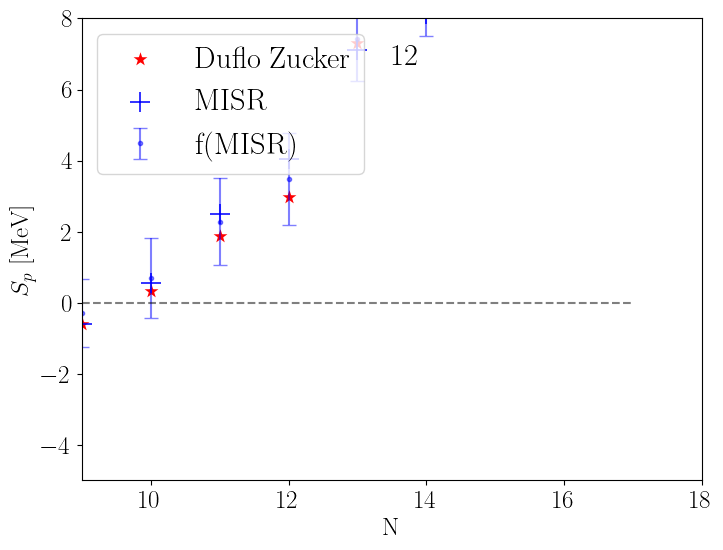

In [75]:
plot_sp_energy(errors_ensemble[1][0], errors_ensemble[1][1]-3, errors_ensemble[1][1]+5, f"{errors_ensemble[1][1]}")